## Tutorial on chemical reaction network (CRN) inference

Dependecies: `Catalyst, OrdinaryDiffEq, CairoMakie, Colors, Optim, LineSearches`

### Simulating a CRN

Fisrt, we simulate a synthetic dataset based on the following CRN, i.e. our ground-truth CRN:
$$ X_1\xrightarrow[]{k_{1}}X_2, \qquad X_1+X_2\xrightleftharpoons[k_{13}]{k_{18}}X_3.$$
The subscripts of the reaction rate constants will be explained later when we introduce the library CRN.

The `@reaction_network` macro from `Catalyst.jl` enables us to programatically define CRNs. Note that package imports and first calls to functions take longer times to run due to compilation.

In [1]:
using Catalyst

In [2]:
true_crn = @reaction_network begin
	k₁, X₁ --> X₂                # irreversible reaction
	(k₁₈, k₁₃), X₁ + X₂ <--> X₃	 # reversible reaction
end

Model ##ReactionSystem#236:
Unknowns (3): see unknowns(##ReactionSystem#236)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (3): see parameters(##ReactionSystem#236)
  k₁
  k₁₈
  k₁₃

`Catalyst.jl` features functionality to automatically derive the corresponding ordinary differential equation (ODE) system (assuming mass-action kinetics).

In [3]:
convert(ODESystem, true_crn)

Model ##ReactionSystem#236:
Equations (3):
  3 standard: see equations(##ReactionSystem#236)
Unknowns (3): see unknowns(##ReactionSystem#236)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (3): see parameters(##ReactionSystem#236)
  k₁
  k₁₈
  k₁₃

$X_i(t)$ denotes the concentration of species $X_i$ at time $t$. To simulate the dynamics of this ODE system, say over $t\in[0,10]$, we need to define and solve an `ODEProblem`. We will use the initial values $(X_1(0), X_2(0), X_3(0)) = (0,0,1)$ and set the reaction rate constants as $(k_{1},k_{13},k_{18})=(1,1,1)$.

In [4]:
using OrdinaryDiffEq

In [5]:
t_span = (0., 10.) # time interval to solve on
x0map = [:X₁ => 0., :X₂ => 0., :X₃ => 1.] # initial conditions
true_kmap  = (:k₁ => 1., :k₁₈ => 1., :k₁₃ => 1.) # ground-truth reaction rate constants

true_oprob = ODEProblem(true_crn, x0map, t_span, true_kmap)
true_sol = solve(true_oprob)

retcode: Success
Interpolation: 3rd order Hermite
t: 25-element Vector{Float64}:
  0.0
  0.0007064002045583837
  0.00777040225014222
  0.06315968433324934
  0.1928699846865976
  0.36423312918202805
  0.5615034713530583
  0.79145734935309
  1.0488720148516424
  1.3403529510999195
  1.669938434997888
  2.0510666649383342
  2.5207107293442714
  3.0564329842106215
  3.561926125860312
  4.13136698482351
  4.714760215275044
  5.346194682853374
  6.00429719846049
  6.700607279215679
  7.426351301223158
  8.183870090671803
  8.969223219783037
  9.780867179274527
 10.0
u: 25-element Vector{Vector{Float64}}:
 [0.0, 0.0, 1.0]
 [0.0007059012621207238, 0.000706400028394102, 0.9992938493547426]
 [0.00771010220425349, 0.007770168881821247, 0.9922598644569627]
 [0.0592164565262739, 0.06303905903105121, 0.9388722422213375]
 [0.15719382861586914, 0.18975048507473566, 0.8265278431546976]
 [0.2434421842392797, 0.3459354671217682, 0.7053111743194761]
 [0.2947382093072657, 0.5048311193098635, 0.600215335691

Next, we extract the ODE solution at $101$ equally-spaced time points `t_obs`. Note that `true_sol(t_obs).u` is a vector of vectors (one vector per time point). We concatenate these vectors into a matrix (one column per time point).

In [6]:
n_obs = 101
t_obs = range(t_span..., n_obs)
data_noiseless = reduce(hcat, true_sol(t_obs).u)

3×101 Matrix{Float64}:
 0.0  0.0901911  0.16171   0.216322  …  0.0135083  0.0131308  0.0127647
 0.0  0.0995337  0.196541  0.28922      1.91539    1.91768    1.9199
 1.0  0.905138   0.820874  0.747229     0.0355485  0.0345941  0.0336656

To simulate noisy data, we introduce additive normal noise (independently and identically distributed) with standard deviation $\sigma=0.01$, and clamp the values to be nonnegative.

In [7]:
using Random
Random.seed!(1) # for reproducibility

σ = 0.01
data = data_noiseless .+ σ .* randn(size(data_noiseless)) # additive normal noise
data = max.(data, 0) # clamp negative values to 0

3×101 Matrix{Float64}:
 0.000619327  0.0906577  0.16347   …  0.0281459  0.0285949  0.00884948
 0.00278406   0.110392   0.205195     1.90582    1.91184    1.92575
 0.994042     0.889372   0.792972     0.0452687  0.0392716  0.0333524

We plot the noisy data along with the groud-truth trajectories. To plot the trajectories, we extract the ODE solution for a dense grid of timepoints. 

In [8]:
# Plotting setup
using CairoMakie
using Colors
set_theme!(theme_latexfonts());
update_theme!(
	Axis=(;
		xgridvisible=false, ygridvisible=false,
		xlabelsize=16, ylabelsize=16,
		titlesize=16,
	),
)
palette = Makie.wong_colors();
lighten(c, w) = RGB((1 .- (1 .- [c.r, c.g, c.b]).*w)...); # lighten color c (w=0 gives white)

In [9]:
# extract ODE solution for dense grid
t_grid = range(t_span..., 1001);
true_sol_grid = true_sol(t_grid);

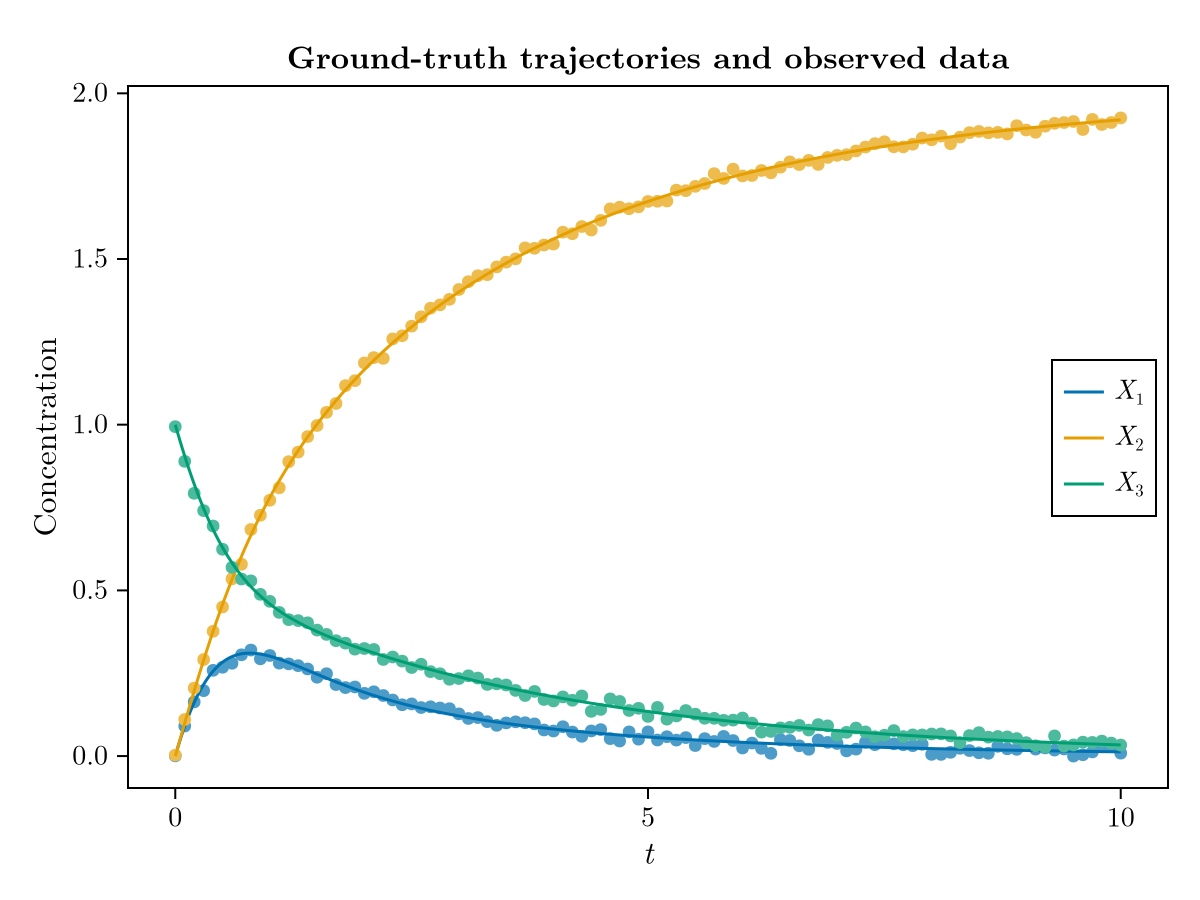

In [10]:
f = Figure()
ax = Axis(f[1,1], xlabel=L"$t$", ylabel="Concentration", title="Ground-truth trajectories and observed data")
n_species = size(data, 1)
for i in 1:n_species
    scatter!(t_obs, data[i,:], color=lighten(palette[i], 0.7))
    lines!(t_grid, [pt[i] for pt in true_sol_grid.u], label=L"$X_%$i$") # `L` parses the string as LaTeX, `%$i` substitutes the value of `i`
end
axislegend(position=:rc);
current_figure()

### Standard parameter inference

When investigating a system such as a CRN, simulating data from its ODEs is considered to be a *forward problem*; that is, to produce observations based on a parameterised model of the investigated system. The *inverse problem* involves inferring or estimating the values of the model parameters using observations of the system. For CRNs, the standard inverse problem is to infer the rate constants from observed data, where the **reactions are assumed to be known**. One approach to this inverse problem is to find the rate constants that minimise a loss function that quantifies the discrepancy between the predictions based on those rate constants and the observed data. Here, we use the sum of squared errors in our loss function, while assuming that the initial state $(X_1(0), X_2(0), X_3(0)) = (0,0,1)$ is known.

In [11]:
function loss_func_known_rx(rate_consts)
	oprob = remake(true_oprob, p=(:k₁ => rate_consts[1], :k₁₈ => rate_consts[2], :k₁₃ => rate_consts[3])); 
	sol = try 
		solve(oprob, saveat=t_obs); # simulate the ODE
	catch e
		return Inf # return Inf if the ODE simulation diverges
	end
	sum(abs2.(data .- reduce(hcat, sol.u))) / (2*σ^2)
end

loss_func_known_rx (generic function with 1 method)

Note that the sum of squared errors is divided by $2\sigma^2$, which is taken from the log-density of a normal distribution. We assume that the value of $\sigma$ is known during inference.

In [12]:
loss_func_known_rx([1,1,1]) # small loss value for ground-truth rate constants

167.55051233957516

In [13]:
loss_func_known_rx([0,0,0]) # large loss value for rate constants far from ground truth

1.5751597668722095e6

To obtain estimates of the rate constants, we minimise the loss function using the [BFGS algorithm](https://julianlsolvers.github.io/Optim.jl/stable/algo/lbfgs/), which is based on the first derivatives of the loss function. We have arbitrarily set lower and upper bounds for the rate constants at $10^{-10}$ and $10^{2}$ respectively, and start the optimisation process with random guesses (between $0$ and $1$) for the rate constants.

In [14]:
using Optim
using LineSearches
opt_alg = Fminbox(BFGS(linesearch = LineSearches.BackTracking())); # optimisation algorithm to use

In [15]:
struct FunctionWrapper
    f::Function
end
(wrapper::FunctionWrapper)(arg) = wrapper.f(arg);

In [16]:
Random.seed!(2) # for reproducibility

n_true_rx = length(true_kmap)
# bounds for rate constants
lower_bounds = 1e-10 .* ones(n_true_rx)
upper_bounds = 1e2 .* ones(n_true_rx)
# initial guess for rate constants (guess between 0 and 1)
start_pt = rand(n_true_rx)

res = optimize(FunctionWrapper(loss_func_known_rx), lower_bounds, upper_bounds, start_pt, opt_alg; autodiff = :forward)

 * Status: success

 * Candidate solution
    Final objective value:     1.673529e+02

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.10e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    3
    f(x) calls:    144
    ∇f(x) calls:   67


We check that the inferred rate constants, i.e. the rate constants which minimise the loss function, have values close to the ground truth $(k_{1},k_{13},k_{18})=(1,1,1)$.

In [17]:
res.minimizer

3-element Vector{Float64}:
 0.9987720445549861
 0.9951018371614704
 0.9970354573790878

In practice, rate constants can vary over multiple scales across the reactions. It is therefore [recommended for optimisation to be performed at a log scale](https://doi.org/10.1093/bioinformatics/bty736), as we show below. We take the exponential of the optimised solution to transform it back to original scale of rate constants.

In [18]:
loss_func_known_rx_exp(θ) = loss_func_known_rx(exp.(θ)) # exp undoes the log transformation
res = optimize(FunctionWrapper(loss_func_known_rx_exp), log.(lower_bounds), log.(upper_bounds), log.(start_pt), opt_alg; autodiff = :forward)

 * Status: success

 * Candidate solution
    Final objective value:     1.673529e+02

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.72e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    477
    ∇f(x) calls:   74


In [19]:
exp.(res.minimizer)

3-element Vector{Float64}:
 0.9987748980994816
 0.9950737431137989
 0.9970243277422619

### Defining a library CRN for structural inference

But what if the set of **reactions in the CRN are unknown**? Here, we come to an inverse problem concerning the *structure* of a model. Instead of assuming knowledge of the precise set of reactions involved in the system, we specify a set of *candidate reactions*, a small subset of which we assume are able to satisfactorily explain the observed data. We call the CRN formed by all candidate reactions the *library CRN*. For this tutorial, the reactants and products of each reaction are one of the complexes $\{X_1,X_2,X_3,X_1+X_2,X_2+X_3,X_1+X_3\}$, and must be distinct. This results in $6\times 5=30$ candidate reactions. Instead of using the `@reaction_network` macro, here we [build a `ReactionSystem` programmatically](https://docs.sciml.ai/Catalyst/stable/model_creation/programmatic_CRN_construction/), which requires us to manually define the independent variable (time), the species, and the vector of reactions along with the rate constants as parameters.

In [41]:
t = default_t(); # time variable
xs = @species X₁(t) X₂(t) X₃(t)

complexes_vec = [xs[idx_vec] for idx_vec in [[1], [2], [3], [1, 2], [2, 3], [1, 3]]]; # all possible complexes
# define all ordered pairs of distinct complexes for reactions
rct_prd_pairs = [
	(reactants, products) for reactants in complexes_vec for products in complexes_vec 
	if reactants !== products
];
n_rx = length(rct_prd_pairs); # number of reactions
@parameters k[1:n_rx] # reaction rate constants
rx_vec = [
	Reaction(kval, reactants, products) for ((reactants, products), kval) in zip(rct_prd_pairs, k)
];

@named lib_crn = ReactionSystem(rx_vec, t, xs, k) # library CRN
lib_crn = complete(lib_crn) # `lib_crn` is defined using the `ReactionSystem` constructor, and so has to be manually marked as complete

Model lib_crn:
Unknowns (3): see unknowns(lib_crn)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (30): see parameters(lib_crn)
  k[1]
  k[2]
  k[3]
  k[4]
  k[5]
  k[6]
  ⋮

Bonus: The `Latexify` package produces LaTeX strings from Julia objects. Displaying the LaTeX results in Jupyter notebooks renders it (like the cell above), printing it produces the raw strings (see suppressed cell below).

In [21]:
using Latexify
print(latexify(lib_crn))

\begin{align*}
\require{mhchem} 
\mathrm{\mathtt{X_1}} &\xrightarrow{k_{1}} \mathrm{\mathtt{X_2}} \\
\mathrm{\mathtt{X_1}} &\xrightarrow{k_{2}} \mathrm{\mathtt{X_3}} \\
\mathrm{\mathtt{X_1}} &\xrightarrow{k_{3}} \mathrm{\mathtt{X_1}} + \mathrm{\mathtt{X_2}} \\
\mathrm{\mathtt{X_1}} &\xrightarrow{k_{4}} \mathrm{\mathtt{X_2}} + \mathrm{\mathtt{X_3}} \\
\mathrm{\mathtt{X_1}} &\xrightarrow{k_{5}} \mathrm{\mathtt{X_1}} + \mathrm{\mathtt{X_3}} \\
\mathrm{\mathtt{X_2}} &\xrightarrow{k_{6}} \mathrm{\mathtt{X_1}} \\
\mathrm{\mathtt{X_2}} &\xrightarrow{k_{7}} \mathrm{\mathtt{X_3}} \\
\mathrm{\mathtt{X_2}} &\xrightarrow{k_{8}} \mathrm{\mathtt{X_1}} + \mathrm{\mathtt{X_2}} \\
\mathrm{\mathtt{X_2}} &\xrightarrow{k_{9}} \mathrm{\mathtt{X_2}} + \mathrm{\mathtt{X_3}} \\
\mathrm{\mathtt{X_2}} &\xrightarrow{k_{10}} \mathrm{\mathtt{X_1}} + \mathrm{\mathtt{X_3}} \\
\mathrm{\mathtt{X_3}} &\xrightarrow{k_{11}} \mathrm{\mathtt{X_1}} \\
\mathrm{\mathtt{X_3}} &\xrightarrow{k_{12}} \mathrm{\mathtt{X_2}} \\
\mat

### Parameter estimation for the library CRN

To infer the set of reactions present in the system, we seek to estimate the rate constants of all reactions of the library CRN, with prior knowledge that most of these rate constants are zero. To this end, we minimise an objective function that is the sum of our original loss function and a penalty function that increases with the rate constants. Similar to [Hoffmann et al. (2019)](https://doi.org/10.1063/1.5066099), we use an $L_1$ penalty, i.e. each rate constant $k$ incurs a penalty of $\lambda k$ for some hyperparameter $\lambda$.

In [43]:
# create ODEProblem corresponding to the library CRN
lib_oprob = ODEProblem(lib_crn, x0map, t_span, zeros(n_rx));

function loss_func_unknown_rx(rate_consts)
    # `k` is the variable name defined along with the library CRN
	oprob = remake(lib_oprob, p=[k => rate_consts]);
	sol = try 
		solve(oprob, saveat=t_obs); # simulate the ODE
	catch e
		return Inf # return Inf if the ODE simulation diverges
	end
	sum(abs2.(data .- reduce(hcat, sol.u))) / (2*σ^2)
end

λ = 1.0 # penalty hyperparameter
# we optimise on log space, so θ = log k
penalised_func(θ) = loss_func_unknown_rx(exp.(θ)) + λ*sum(exp.(θ))

penalised_func (generic function with 1 method)

In [44]:
# sanity check for `penalised_func`
true_kvec = zeros(n_rx);
true_kvec[1] = true_kvec[13] = true_kvec[18] = 1.
penalised_func(log.(true_kvec))

170.55051233957516

Since the optimisation problem is more high-dimensional this time, we perform optimisation multiple times from different starting points.

In [24]:
Random.seed!(3) # for reproducibility

# bounds for rate constants
lower_bounds = 1e-10 .* ones(n_rx)
upper_bounds = 1e2 .* ones(n_rx)
# initial guesses for rate constants (guess between 0 and 1)
n_start = 15
start_pt = rand(n_rx)

res = optimize(FunctionWrapper(penalised_func), log.(lower_bounds), log.(upper_bounds), log.(start_pt), opt_alg; autodiff = :forward)

 * Status: success

 * Candidate solution
    Final objective value:     1.645799e+02

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.63e+00 ≰ 1.0e-08

 * Work counters
    Seconds run:   24  (vs limit Inf)
    Iterations:    8
    f(x) calls:    1380
    ∇f(x) calls:   634


To check if the optimisation result is sensible, we reconstruct ODE trajectories from the optimisation solution, and compare them to the ground truth trajectories.

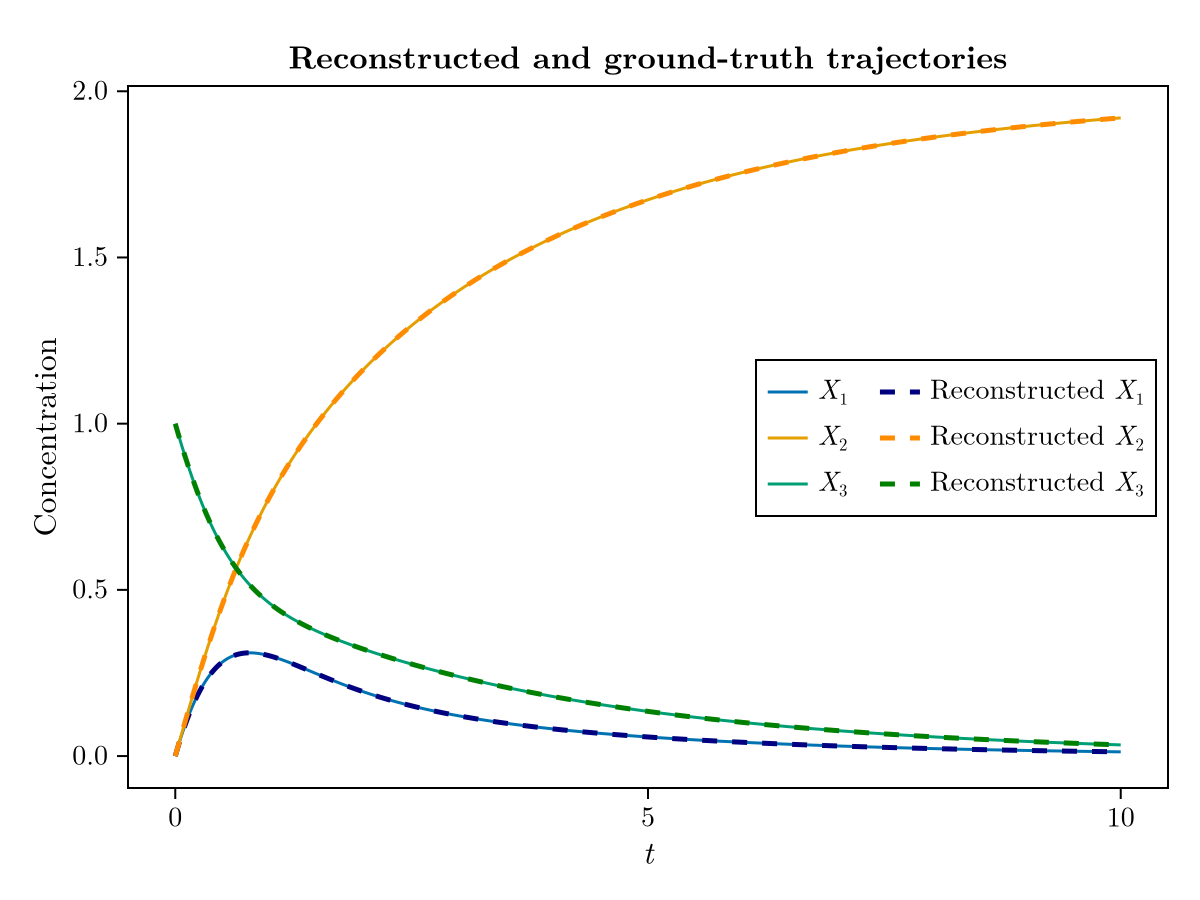

In [25]:
f = Figure()
ax = Axis(f[1,1], xlabel=L"$t$", ylabel="Concentration", title="Reconstructed and ground-truth trajectories")
est_kvec = exp.(res.minimizer)
recon_oprob = remake(lib_oprob, p=[k => est_kvec])
recon_sol_grid = solve(recon_oprob)(t_grid)
for i in 1:n_species
    lines!(t_grid, [pt[i] for pt in true_sol_grid.u], label=L"$X_%$i$", color=palette[i])
    lines!(
        t_grid, [pt[i] for pt in true_sol_grid.u], label=L"Reconstructed $X_%$i$", 
        color=[:navy, :darkorange, :green][i], linestyle=:dash, linewidth=2.5
    )
end
axislegend(position=:rc, nbanks=2);
current_figure()

The reconstructed trajectories resembles the ground truth well, so we move on to validating the rate constant estimates. Again, we compare the estimated rate constants with the ground truth. 

In [26]:
est_kvec[[1,13,18]]

3-element Vector{Float64}:
 0.8923295631134235
 2.8121628637670985e-5
 0.9580365518160175

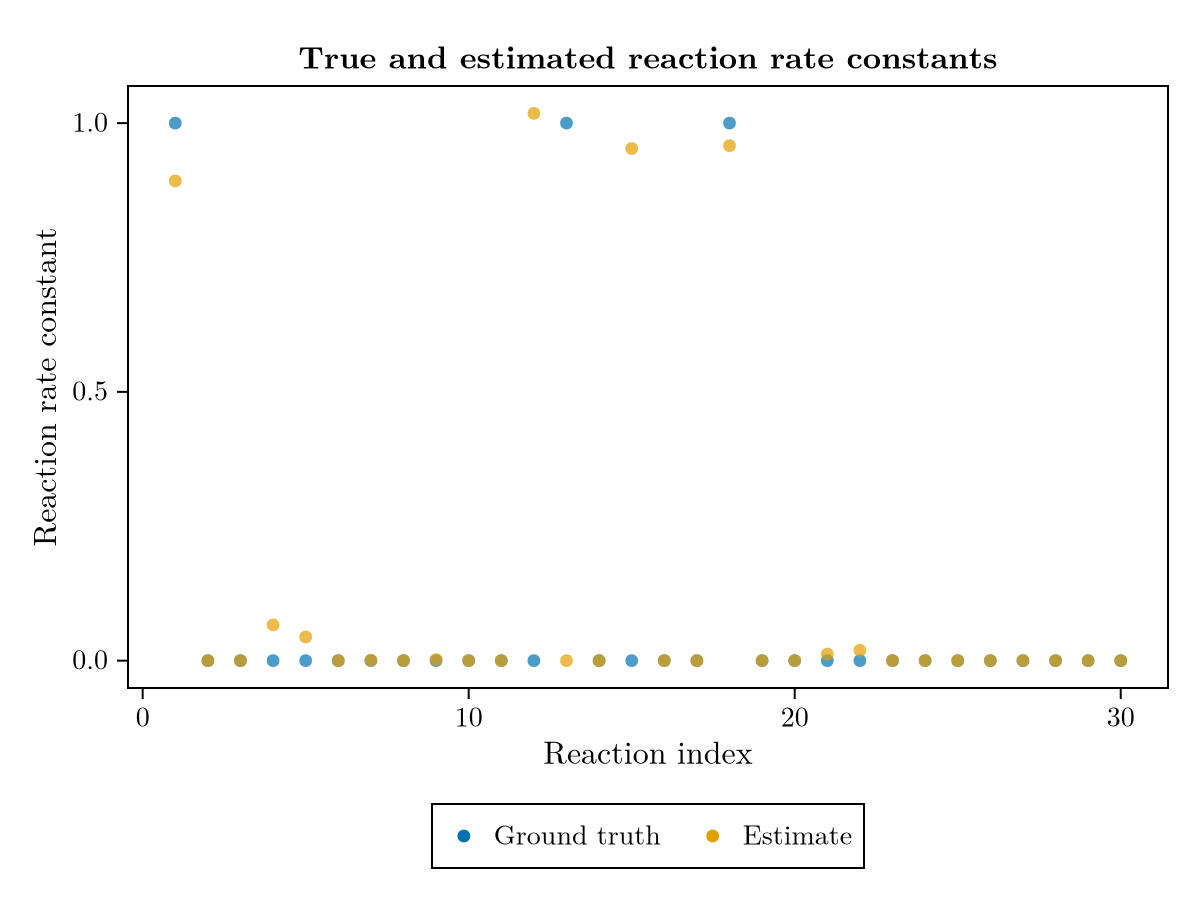

In [27]:
f = Figure()
title = "True and estimated reaction rate constants"
ax = Axis(
    f[1,1], title=title, xlabel="Reaction index", ylabel="Reaction rate constant"
)
scatter!(1:n_rx, true_kvec, alpha=0.7, label="Ground truth")
scatter!(1:n_rx, est_kvec, alpha=0.7, label="Estimate")
f[2, 1] = Legend(f, ax, orientation=:horizontal);
current_figure()

The rate constants for reactions $1$ and $18$ are underestimated, but reaction $13$ is missed by our inference procedure. We refer to this as a *false negative*. Instead, reactions $12$ and $15$ have rate constant estimates close to $1$, which corresponds to *false positives*. Our inferred CRN is different from the ground truth, yet the trajectories are reconstructed closely. This reflects a non-identifiability issue known as *dynamical equivalence*.

In [39]:
@named crn_13_only = ReactionSystem(rx_vec[[13]], t, xs, k)
convert(ODESystem, complete(crn_13_only))

Model crn_13_only:
Equations (3):
  3 standard: see equations(crn_13_only)
Unknowns (3): see unknowns(crn_13_only)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (30): see parameters(crn_13_only)
  k[1]
  k[2]
  k[3]
  k[4]
  k[5]
  k[6]
  ⋮

In [40]:
@named crn_12_15 = ReactionSystem(rx_vec[[12, 15]], t, xs, k)
convert(ODESystem, complete(crn_12_15))

Model crn_12_15:
Equations (3):
  3 standard: see equations(crn_12_15)
Unknowns (3): see unknowns(crn_12_15)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (30): see parameters(crn_12_15)
  k[1]
  k[2]
  k[3]
  k[4]
  k[5]
  k[6]
  ⋮

In the code above, we see that reactions $12$ and $15$ together contribute the same dynamics as reaction $13$ when $k_{12} = k_{13} = k_{15}$. This explains why we can reconstruct the ground-truth trajectories with a CRN different from the ground truth. However, this also reveals that the minimum found by our optimisation procedure is not a *global* minimum, as the solution we found incurs an unncessary penalty in the form of reactions $12$ and $15$ instead of reaction $13$. The standard remedy for optimisation problems that get stuck in suboptimal local minima is to perform multiple optimisation runs each with different starting points (TODO).

### Reaction network inference (outdated)

Given that visual inspection is insufficient to infer which reactions are present in the CRN, we aim to perform this inference quantitatively instead. There are multiple approaches to this requiring varying levels of computational effort (see variable selection in regression problems), here we develop a method that is rather *ad hoc* but quick-to-compute.

To get a parsimonious CRN, we sequentially include entries of the rate constant vector (from the largest values) until the model fit is similar to the model fit with all estimated constants. For this part, we quantify model fit via the loss function without any penalty function.

In [28]:
full_loss = loss_func_unknown_rx(est_kvec)
tmp_kvec = zeros(n_rx)
for (num, idx) in  enumerate(reverse(sortperm(est_kvec)))
    tmp_kvec[idx] = est_kvec[idx]
    loss_offset = loss_func_unknown_rx(tmp_kvec) - full_loss
    println("Number of reactions = $num, Loss offset = $loss_offset")
end

Number of reactions = 1, Loss offset = 232899.93978378712
Number of reactions = 2, Loss offset = 232899.93978378712
Number of reactions = 3, Loss offset = 548915.7960732649
Number of reactions = 4, Loss offset = 2779.9070243086367
Number of reactions = 5, Loss offset = 38.5418436895759
Number of reactions = 6, Loss offset = 1221.159907906521
Number of reactions = 7, Loss offset = 110.77201674346222
Number of reactions = 8, Loss offset = 180.87628106240473
Number of reactions = 9, Loss offset = 3.3133898465305833
Number of reactions = 10, Loss offset = 0.009321385537106153
Number of reactions = 11, Loss offset = 0.004379009428333802
Number of reactions = 12, Loss offset = 0.0030074865469202905
Number of reactions = 13, Loss offset = 0.0035519307115237098
Number of reactions = 14, Loss offset = 0.0031127884762156555
Number of reactions = 15, Loss offset = 0.0019079285494285614
Number of reactions = 16, Loss offset = 0.0021528903527610055
Number of reactions = 17, Loss offset = 0.00247833

The difference in loss function is insignificant after the $11$ reactions with the largest rate constant estimates are included. The reactions that we infer to be present in the CRN are shown below. The first 3 reactions are in the ground-truth CRN, while the other 8 reactions are extraneous, which we refer to as *false positives*.

In [29]:
println(reverse(sortperm(est_kvec))[1:11])

[12, 18, 15, 1, 4, 5, 22, 21, 9, 7, 11]


### Hyperparameter tuning

At this point, one could potentially obtain a more parsimonious CRN by repeating the estimation/inference procedure with these $11$ reactions (instead of the original $30$ reactions). However, one could also obtain a more parsimonious CRN by adjusting the penalty hyperparameter $\lambda$. Here, we repeat the estimation for a range of values of $\lambda$, namely $\lambda = 2^j$ for $j=-3,\ldots,6$, and visualise the model fit of the resulting optimisation solutions (again via the un-penalised loss function).

In [30]:
λvec = 2.0 .^ (-3:6)
resvec = [];
for λval in λvec
    penalised_func(θ) = loss_func_unknown_rx(exp.(θ)) + λval*sum(exp.(θ))
    res = optimize(FunctionWrapper(penalised_func), log.(lower_bounds), log.(upper_bounds), log.(start_pt), opt_alg; autodiff = :forward)
    push!(resvec, res)
end

In [31]:
kvecs = [exp.(res.minimizer) for res in resvec];
loss_vals = loss_func_unknown_rx.(kvecs);
for (λval, loss_val) in zip(λvec, loss_vals)
    println("λ = $λval, Loss = $loss_val")
end

λ = 0.125, Loss = 160.26928514448372
λ = 0.25, Loss = 159.73261540925657
λ = 0.5, Loss = 160.26175252827662
λ = 1.0, Loss = 160.61336911573298
λ = 2.0, Loss = 160.0948108028458
λ = 4.0, Loss = 160.95393679867703
λ = 8.0, Loss = 159.6619066053936
λ = 16.0, Loss = 159.85674287714747
λ = 32.0, Loss = 162.54942581563668
λ = 64.0, Loss = 164.0538934684783


### Alternative penalty function